In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle

In the features, 1 means "yes" and 0 means "no"

In [ ]:
# ---------- 1. Model for ICU Prediction ----------

=== Training Metrics ===
F1 Score: 0.9150772488417925
Accuracy: 0.9152545446851215
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91    165413
         1.0       0.88      0.96      0.92    165413

    accuracy                           0.92    330826
   macro avg       0.92      0.92      0.92    330826
weighted avg       0.92      0.92      0.92    330826


=== Test Metrics ===
F1 Score: 0.8589817179581224
Accuracy: 0.8590136629170086
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.86     41426
         1.0       0.85      0.87      0.86     41426

    accuracy                           0.86     82852
   macro avg       0.86      0.86      0.86     82852
weighted avg       0.86      0.86      0.86     82852



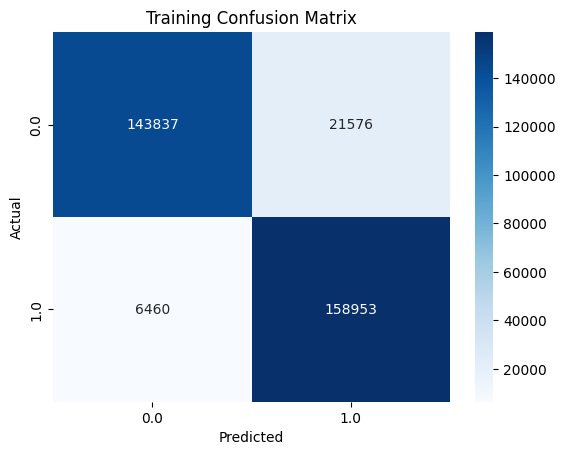

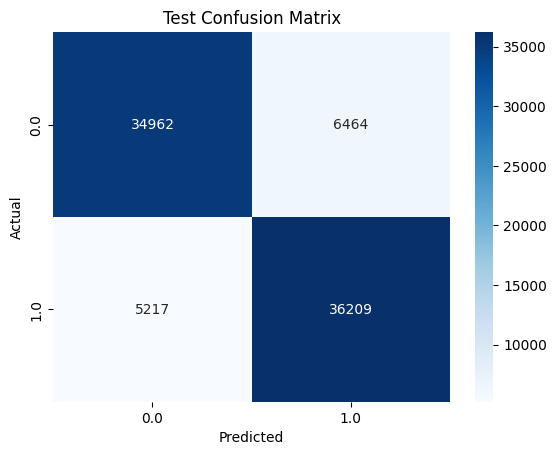

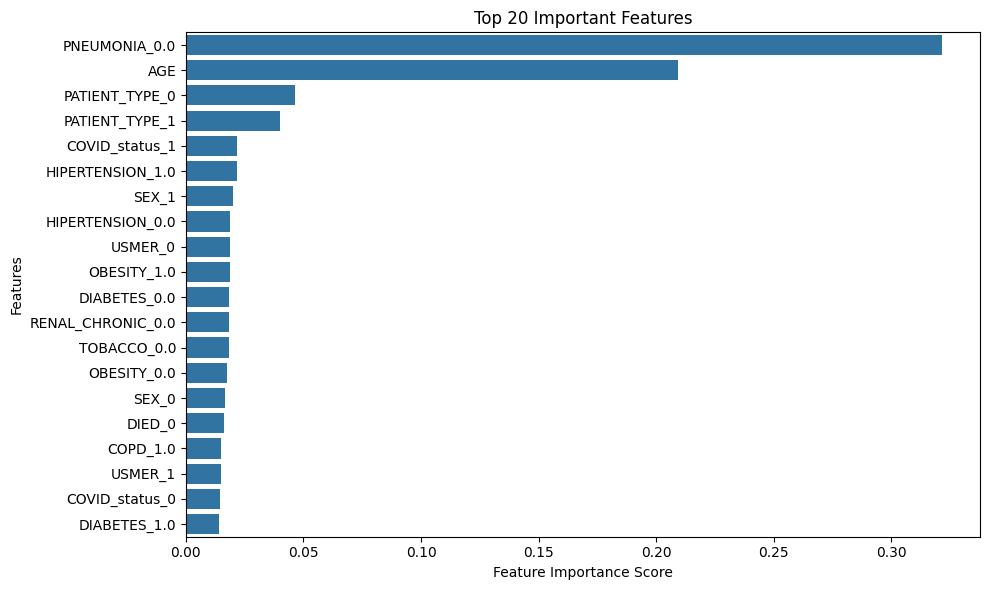

In [16]:

# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Drop INTUBED and handle missing ICU
df = df.drop(columns=["INTUBED"])
df = df.dropna(subset=["ICU"])
icu_target = df["ICU"]
df = df.drop(columns=["ICU"])
df = df.dropna()
icu_target = icu_target.loc[df.index]  # Align with cleaned df

# Step 3: Convert categorical columns to string
for col in df.columns:
    if col != "AGE":
        df[col] = df[col].astype(str)

# Step 4: Train/test split BEFORE encoding
X_train, X_test, y_train, y_test = train_test_split(df, icu_target, test_size=0.2, random_state=42)

# Step 5: One-hot encode after split using OneHotEncoder
categorical_cols = [col for col in df.columns if col != 'AGE']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

# Save the encoder for use in Flask later
with open('encoder_ICU.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Transform train and test
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert to DataFrames with column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Add back AGE
X_train_final = pd.concat([X_train[['AGE']], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[['AGE']], X_test_encoded_df], axis=1)

# Step 6: SMOTE
smote_1 = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote_1.fit_resample(X_train_final, y_train)

smote_2 = SMOTE(random_state=42)
X_test_smote, y_test_smote = smote_2.fit_resample(X_test_final, y_test)

# Step 7: Train classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train_smote)
y_test_pred = clf.predict(X_test_smote)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train_smote, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smote, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test_smote, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test_smote, y_test_pred))
print("Classification Report:\n", classification_report(y_test_smote, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train_smote, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test_smote, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_train_smote.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [17]:
# === Save previously trained model and feature list ===
joblib.dump(clf, "icu_model.pkl")
joblib.dump(X_train_smote.columns.tolist(), "icu_features.pkl")

['icu_features.pkl']

In [18]:
# === Load model, scaler, and feature names ===
loaded_clf = joblib.load("icu_model.pkl")
model_features = joblib.load("icu_features.pkl")

In [12]:
loaded_clf

DecisionTreeClassifier(random_state=42)

In [13]:
model_features

['AGE',
 'USMER_0',
 'USMER_1',
 'SEX_0',
 'SEX_1',
 'PATIENT_TYPE_0',
 'PATIENT_TYPE_1',
 'PNEUMONIA_0.0',
 'PNEUMONIA_1.0',
 'DIABETES_0.0',
 'DIABETES_1.0',
 'COPD_0.0',
 'COPD_1.0',
 'ASTHMA_0.0',
 'ASTHMA_1.0',
 'INMSUPR_0.0',
 'INMSUPR_1.0',
 'HIPERTENSION_0.0',
 'HIPERTENSION_1.0',
 'OTHER_DISEASE_0.0',
 'OTHER_DISEASE_1.0',
 'CARDIOVASCULAR_0.0',
 'CARDIOVASCULAR_1.0',
 'OBESITY_0.0',
 'OBESITY_1.0',
 'RENAL_CHRONIC_0.0',
 'RENAL_CHRONIC_1.0',
 'TOBACCO_0.0',
 'TOBACCO_1.0',
 'DIED_0',
 'DIED_1',
 'COVID_status_0',
 'COVID_status_1']

In [ ]:
# ---------- 2. Model for PATIENT_TYPE Prediction ----------

=== Training Metrics ===
F1 Score: 0.8348601799322475
Accuracy: 0.8348610218894119
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83    104297
           1       0.83      0.84      0.84    104297

    accuracy                           0.83    208594
   macro avg       0.83      0.83      0.83    208594
weighted avg       0.83      0.83      0.83    208594


=== Test Metrics ===
F1 Score: 0.7175578676938467
Accuracy: 0.7169163054950484
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     25968
           1       0.66      0.68      0.67     18563

    accuracy                           0.72     44531
   macro avg       0.71      0.71      0.71     44531
weighted avg       0.72      0.72      0.72     44531



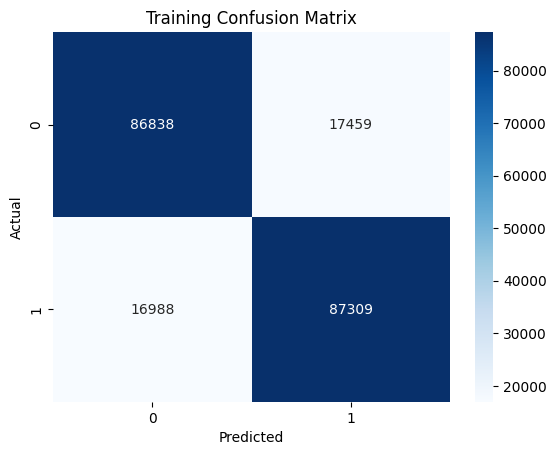

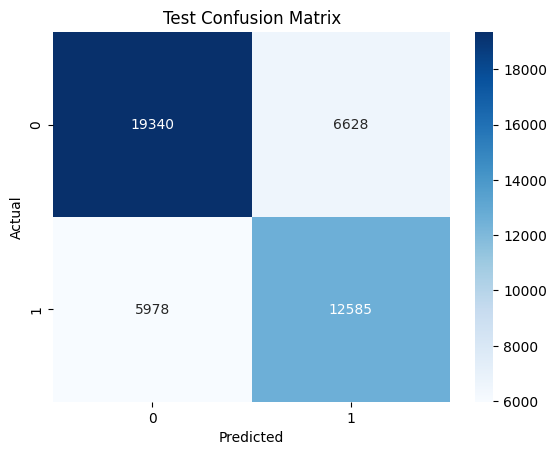

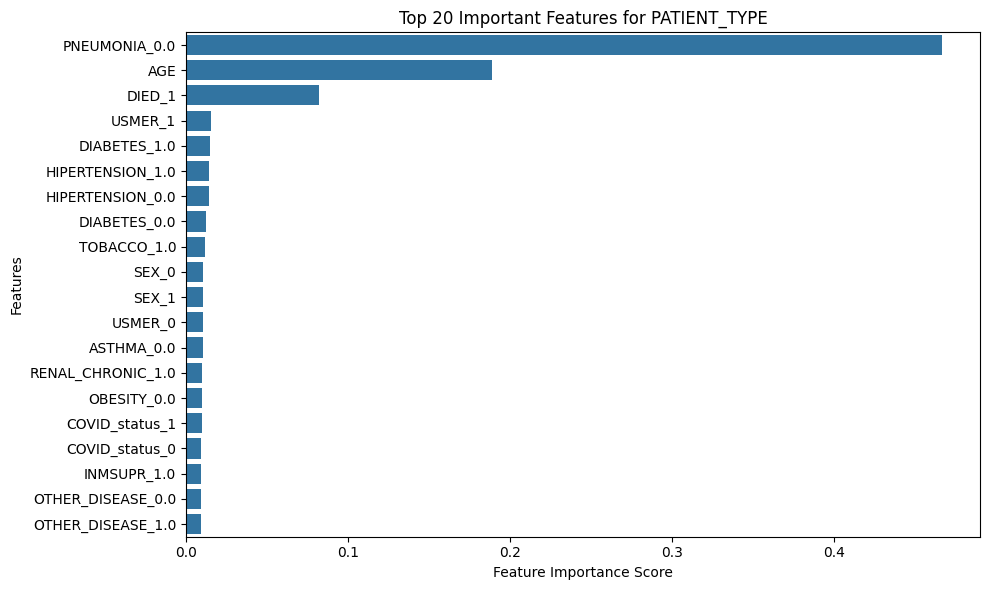

In [19]:

# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Drop unwanted columns and handle missing PATIENT_TYPE
df = df.drop(columns=["INTUBED", "ICU"])
df = df.dropna(subset=["PATIENT_TYPE"])
patient_type_target = df["PATIENT_TYPE"]
df = df.drop(columns=["PATIENT_TYPE"])
df = df.dropna()
patient_type_target = patient_type_target.loc[df.index]  # Align target with cleaned df

# Step 3: Convert categorical columns to string
for col in df.columns:
    if col != "AGE":
        df[col] = df[col].astype(str)

# Step 4: Train/test split BEFORE encoding
X_train, X_test, y_train, y_test = train_test_split(df, patient_type_target, test_size=0.2, random_state=42)

# Step 5: One-hot encoding with OneHotEncoder
categorical_cols = [col for col in df.columns if col != "AGE"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

# Save encoder for Flask use
with open('encoder_patient_type.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Transform training and test data
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Add AGE back to encoded data
X_train_final = pd.concat([X_train[['AGE']], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[['AGE']], X_test_encoded_df], axis=1)

# Step 6: SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

# Step 7: Train the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Step 8: Predictions
y_train_pred = clf.predict(X_train_smote)
y_test_pred = clf.predict(X_test_final)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train_smote, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smote, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train_smote, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature importance
importances = pd.Series(clf.feature_importances_, index=X_train_smote.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features for PATIENT_TYPE')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [20]:
# === Save the trained PATIENT_TYPE model, scaler, and feature list ===
joblib.dump(clf, "patient_type_model.pkl")
joblib.dump(X_train_smote.columns.tolist(), "patient_type_features.pkl")

['patient_type_features.pkl']

In [21]:
# === Load the PATIENT_TYPE model, scaler, and feature names ===
loaded_clf = joblib.load("patient_type_model.pkl")
model_features = joblib.load("patient_type_features.pkl")